<img src="https://github.com/Henriquerezer/Microsoft-PHI_3-LLM/assets/87787728/7dff7714-386f-4eb4-a5bc-4e1ba8790aa1" width="600" height="600" alt="description">


Uma apólice de seguro é um acordo pelo qual uma empresa se compromete a fornecer uma garantia de compensação por perda, dano, doença ou morte especificados em troca do pagamento de um prêmio especificado. Um prêmio é uma soma de dinheiro que o cliente precisa pagar regularmente a uma companhia de seguros por essa garantia.

Por exemplo, você pode pagar um prêmio de R$ 5.000 cada ano por uma cobertura de seguro saúde de R$ 200.000 para que, se Deus o livre, você adoeça e precise ser hospitalizado naquele ano, a empresa provedora do seguro arcará com o custo da hospitalização, etc., até R$. 200.000. Agora, se você está se perguntando como a empresa pode arcar com custos tão altos de hospitalização quando cobra apenas um prêmio de R$ 5.000, é aí que entra o conceito de probabilidades. Por exemplo, como você, pode haver 100 clientes que pagariam um prêmio de Rs 5.000 todo ano, mas apenas alguns deles (digamos 2-3) seriam hospitalizados naquele ano, e não todos. Desta forma, todos compartilham o risco de todos os outros.

Assim como o seguro médico, há o seguro de veículos onde todo ano o cliente precisa pagar um prêmio de um determinado valor à companhia provedora de seguros para que, em caso de acidente infeliz com o veículo, a companhia provedora de seguros forneça compensação (chamada de 'soma assegurada') ao cliente.

Construir um modelo para prever se um cliente estaria interessado em Seguro de Veículo é extremamente útil para a empresa porque ela pode, então, planejar adequadamente sua estratégia de comunicação para alcançar esses clientes e otimizar seu modelo de negócios e receita.

Agora, para prever se o cliente estaria interessado em Seguro de Veículo, você tem informações sobre demografia (gênero, idade, tipo de código de região), Veículos (Idade do Veículo, Danos), Política (Prêmio, canal de origem), etc.

## Descrição dos dados
**id:** ID de Identificação do Cliente

**Gender:** Gênero do Cliente

**Age:** Idade do Cliente

**Driving_License	0 :** Para o Cliente que não possui CNH, **1 :** Para o Cliente que possui CNH

**Region_Code:** Còdigo de identificação da Região do Cliente

**Previously_Insured	1 :** Cliente já possui Seguro Automóvel, **0 :** Cliente não possui Seguro Automóvel

**Vehicle_Age:** Idade do Veículo

**Vehicle_Damage	1 :** O cliente teve seu veículo danificado no passado. **0 :** O cliente não teve seu veículo danificado no passado.

**Annual_Premium:**	O valor que o cliente precisa pagar como prêmio no ano

**PolicySalesChannel:**	Código anonimizado para o canal de divulgação ao cliente, ou seja. Diferentes agentes, por correio, por telefone, pessoalmente, etc.

**Vintage:**	Número de dias em que o cliente esteve associado à empresa

**Response	1 :** O cliente está interessado, **0 :** O cliente não está interessado

# Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

# Importando dados

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
train.shape

(381109, 12)

In [5]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

**Não há dados faltantes**

In [6]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [7]:
#Excluindo a coluna ID que será desconsiderada e colunas do tipo string

train.drop(['id','Vehicle_Age','Vehicle_Damage','Gender'],axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,540165.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


In [8]:
def grab_col_names(dataframe, cat_th=10, car_th=20):


    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(train)

Observations: 381109
Variables: 12
cat_cols: 6
num_cols: 6
cat_but_car: 0
num_but_cat: 3


In [9]:
cat_cols

['Gender',
 'Vehicle_Age',
 'Vehicle_Damage',
 'Driving_License',
 'Previously_Insured',
 'Response']

In [10]:
num_cols

['id',
 'Age',
 'Region_Code',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

In [11]:
num_cols = [col for col in num_cols if "id" not in col]
num_cols = [col for col in num_cols if "Policy_Sales_Channel" not in col]

        Gender     Ratio
Gender                  
Male    206089  54.07613
Female  175020  45.92387


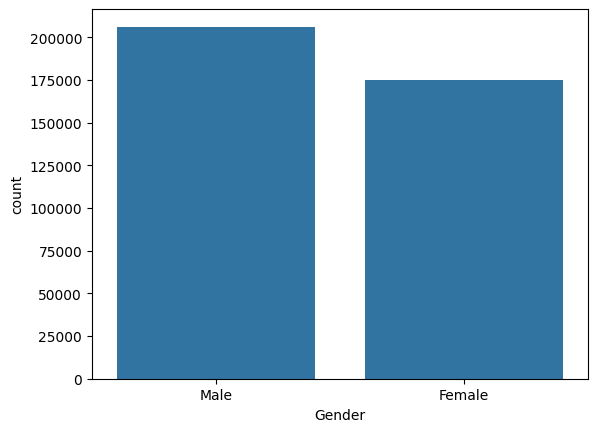

             Vehicle_Age      Ratio
Vehicle_Age                        
1-2 Year          200316  52.561341
< 1 Year          164786  43.238549
> 2 Years          16007   4.200111


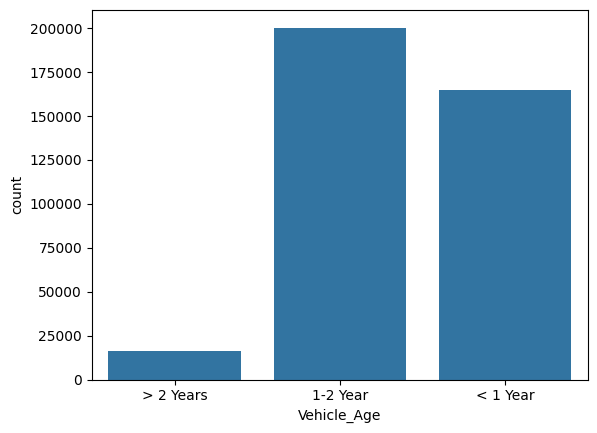

                Vehicle_Damage      Ratio
Vehicle_Damage                           
Yes                     192413  50.487656
No                      188696  49.512344


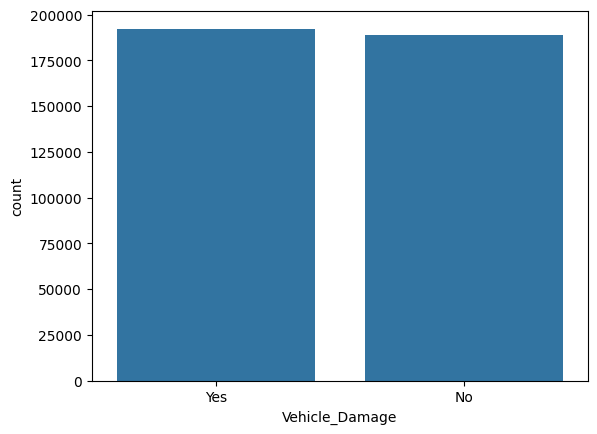

                 Driving_License      Ratio
Driving_License                            
1                         380297  99.786938
0                            812   0.213062


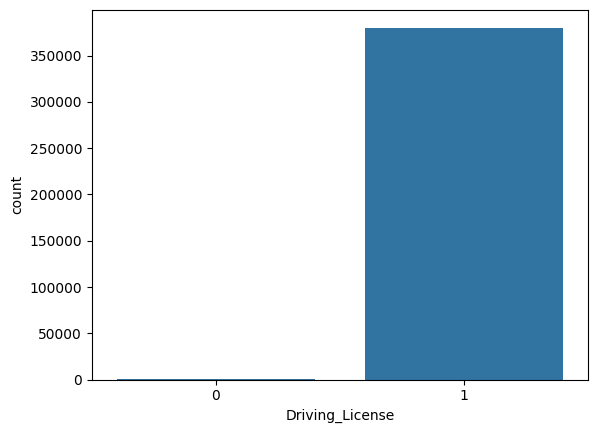

                    Previously_Insured      Ratio
Previously_Insured                               
0                               206481  54.178988
1                               174628  45.821012


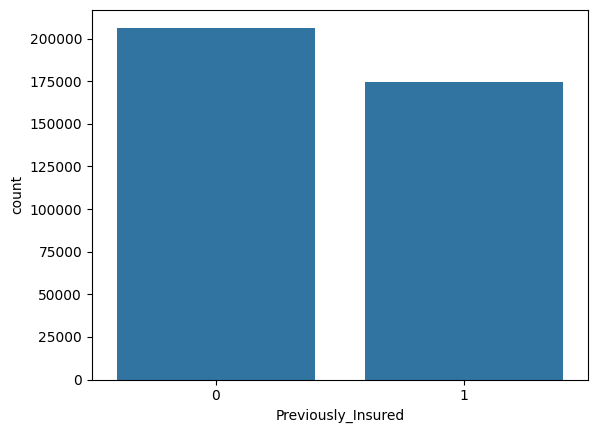

          Response      Ratio
Response                     
0           334399  87.743664
1            46710  12.256336


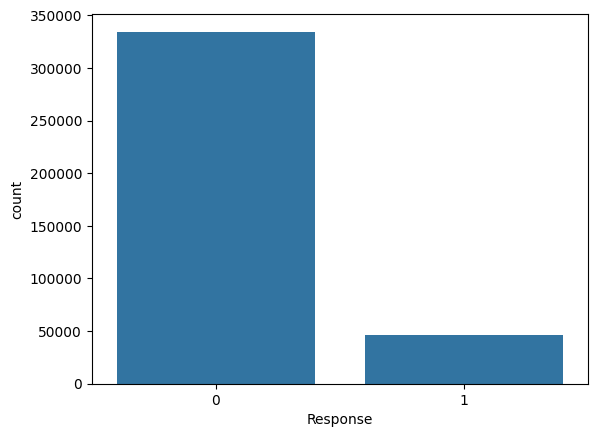

In [12]:
# SUMMARY colunas categorias
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for i in cat_cols:
    cat_summary(train, i, plot=True)

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
5%           21.000000
10%          22.000000
20%          24.000000
30%          25.000000
40%          29.000000
50%          36.000000
60%          42.000000
70%          47.000000
80%          53.000000
90%          62.000000
95%          69.000000
99%          77.000000
max          85.000000
Name: Age, dtype: float64


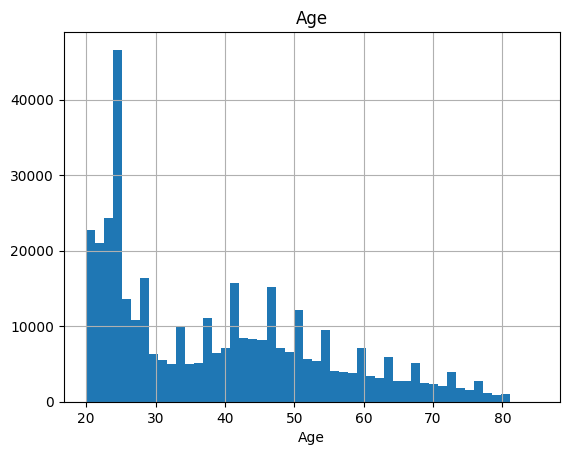

#####################################
count    381109.000000
mean         26.388807
std          13.229888
min           0.000000
5%            5.000000
10%           8.000000
20%          11.000000
30%          18.000000
40%          28.000000
50%          28.000000
60%          28.000000
70%          31.000000
80%          39.000000
90%          46.000000
95%          47.000000
99%          50.000000
max          52.000000
Name: Region_Code, dtype: float64


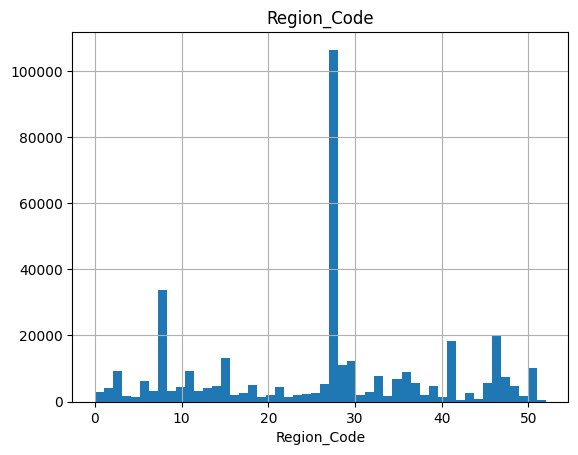

#####################################
count    381109.000000
mean      30564.389581
std       17213.155057
min        2630.000000
5%         2630.000000
10%        2630.000000
20%       21583.600000
30%       26238.000000
40%       29082.000000
50%       31669.000000
60%       34406.000000
70%       37548.000000
80%       41711.000000
90%       48431.000000
95%       55176.000000
99%       72963.000000
max      540165.000000
Name: Annual_Premium, dtype: float64


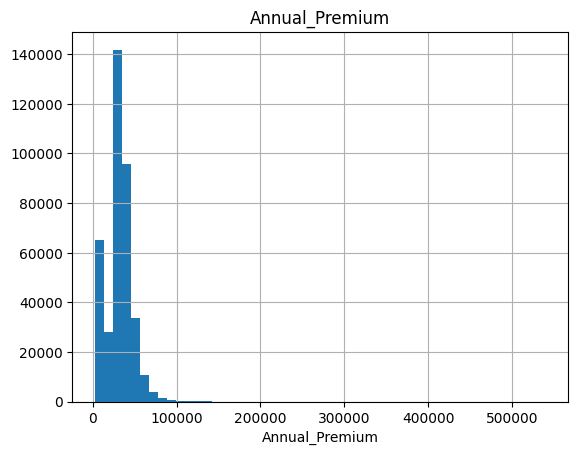

#####################################
count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
5%           24.000000
10%          38.000000
20%          68.000000
30%          96.000000
40%         125.000000
50%         154.000000
60%         183.000000
70%         212.000000
80%         241.000000
90%         270.000000
95%         285.000000
99%         297.000000
max         299.000000
Name: Vintage, dtype: float64


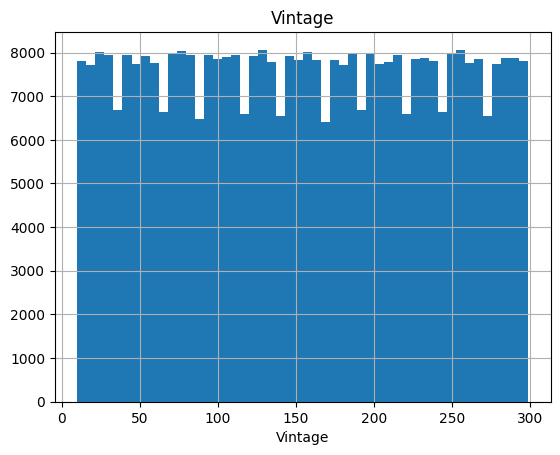

#####################################


In [13]:
# SUMMARY COLUNAS NÚMERICAS
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

for col in num_cols:
    num_summary(train, col, plot=True)

In [14]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [15]:
for col in num_cols:
    target_summary_with_num(train, "Response", col)

                Age
Response           
0         38.178227
1         43.435560


          Region_Code
Response             
0           26.336544
1           26.762963


          Annual_Premium
Response                
0           30419.160276
1           31604.092742


             Vintage
Response            
0         154.380243
1         154.112246




<Axes: xlabel='Age'>

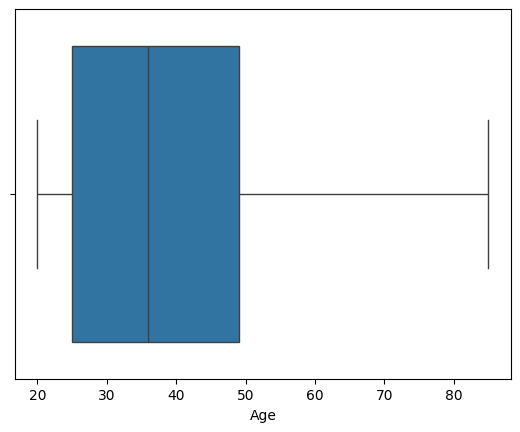

In [16]:
sns.boxplot(x=train["Age"])

<Axes: xlabel='Annual_Premium'>

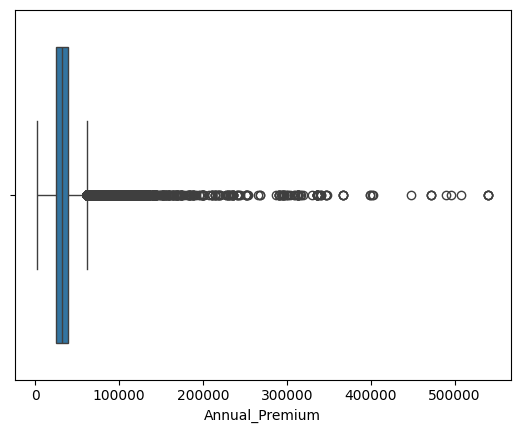

In [17]:
sns.boxplot(x=train["Annual_Premium"])

<Axes: xlabel='Vintage'>

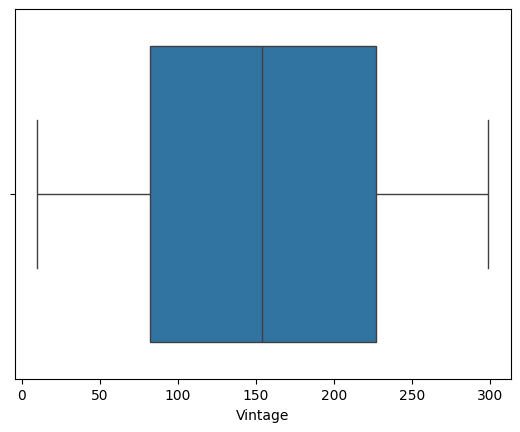

In [18]:
sns.boxplot(x=train["Vintage"])

### Gender-Response Visualization

<Axes: xlabel='count', ylabel='Gender'>

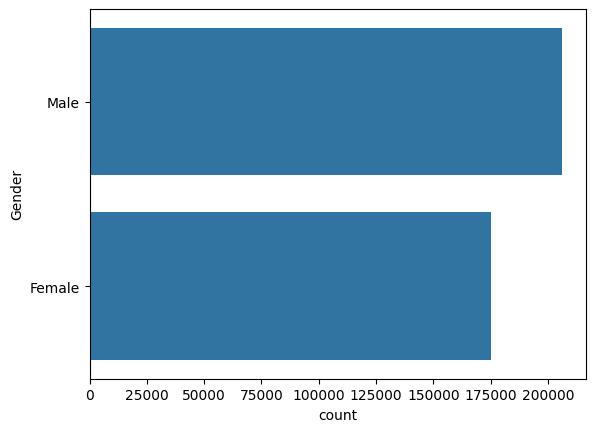

In [19]:
sns.countplot(train.Gender)

In [20]:
df=train.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

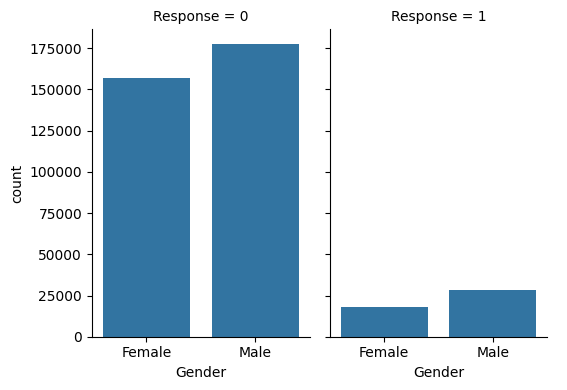

In [21]:
g = sns.catplot(x="Gender", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### Driving license-Gender Visualization

In [22]:
df=train.groupby(['Gender'])['Driving_License'].count().to_frame().reset_index()
df

,Gender,Driving_License
0,Female,175020
1,Male,206089


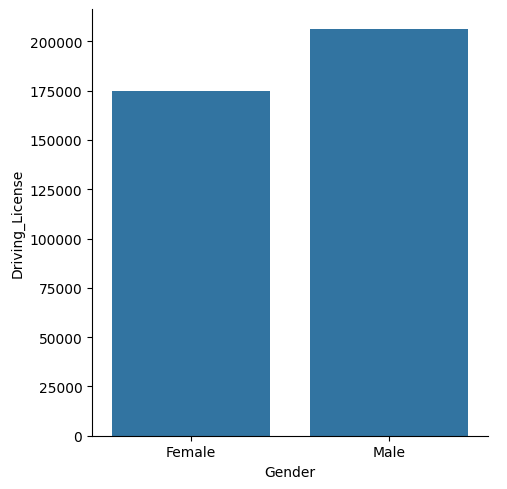

In [23]:
sns.catplot(x="Gender", y="Driving_License",
                data=df, kind="bar");

### Response-Vehicle age Visualization

In [24]:
df=train.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()
df

,Vehicle_Age,Response,count
0,1-2 Year,0,165510
1,1-2 Year,1,34806
2,< 1 Year,0,157584
3,< 1 Year,1,7202
4,> 2 Years,0,11305
5,> 2 Years,1,4702


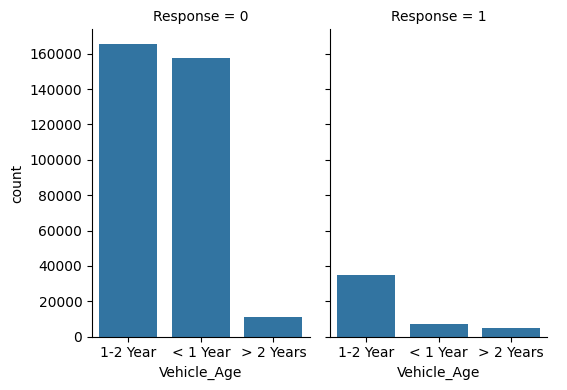

In [25]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

### Damage Vehicle-Response Visualization

In [26]:
df=train.groupby(['Vehicle_Damage','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

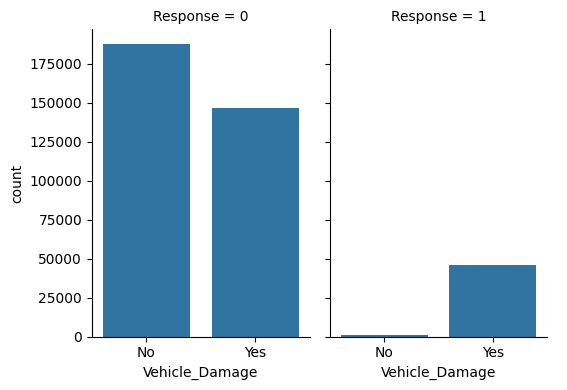

In [27]:
g = sns.catplot(x="Vehicle_Damage", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.7);

# DATA PREPROCESSING

## OUTLIERS

In [28]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 3 * interquantile_range
    low_limit = quartile1 - 3 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [29]:
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False
Region_Code : False
Annual_Premium : True
Vintage : False


In [30]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [31]:
for col in num_cols:
    col, grab_outliers(train, col)

Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
Empty DataFrame
Columns: [id, Gender, Age, Driving_License, Region_Code, Previously_Insured, Vehicle_Age, Vehicle_Damage, Annual_Premium, Policy_Sales_Channel, Vintage, Response]
Index: []
          id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
1412    1413  Female   41                1         28.0                   0   
11319  11320  Female   50                1         46.0                   1   
13426  13427  Female   47                1         28.0                   0   
15024  15025  Female   32                1         28.0                   0   
25532  25533    Male   50                1         28.0                   0   

      Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
1412     1-2 Year            Yes        267698.0                 124.0   

In [32]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [33]:
for col in num_cols:
    replace_with_thresholds(train, col)

In [34]:
# CHECK OUTLIERS AGAIN
for col in num_cols:
    print(f"{col} : {check_outlier(train,col)}")

Age : False


Region_Code : False
Annual_Premium : False
Vintage : False


In [35]:
train.drop(['id','Vehicle_Age','Vehicle_Damage','Gender'],axis =1).quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T

,0.00,0.05,0.50,0.95,0.99,1.00
Age,20.0,21.0,36.0,69.0,77.0,85.0
Driving_License,0.0,1.0,1.0,1.0,1.0,1.0
Region_Code,0.0,5.0,28.0,47.0,50.0,52.0
Previously_Insured,0.0,0.0,0.0,1.0,1.0,1.0
Annual_Premium,2630.0,2630.0,31669.0,55176.0,72963.0,212814.0
Policy_Sales_Channel,1.0,26.0,133.0,160.0,160.0,163.0
Vintage,10.0,24.0,154.0,285.0,297.0,299.0
Response,0.0,0.0,0.0,1.0,1.0,1.0


## CORRELATION ANALYSIS

,1,2,corr
0,Policy_Sales_Channel,Age,-0.892852
28,Age,Age,1.000000


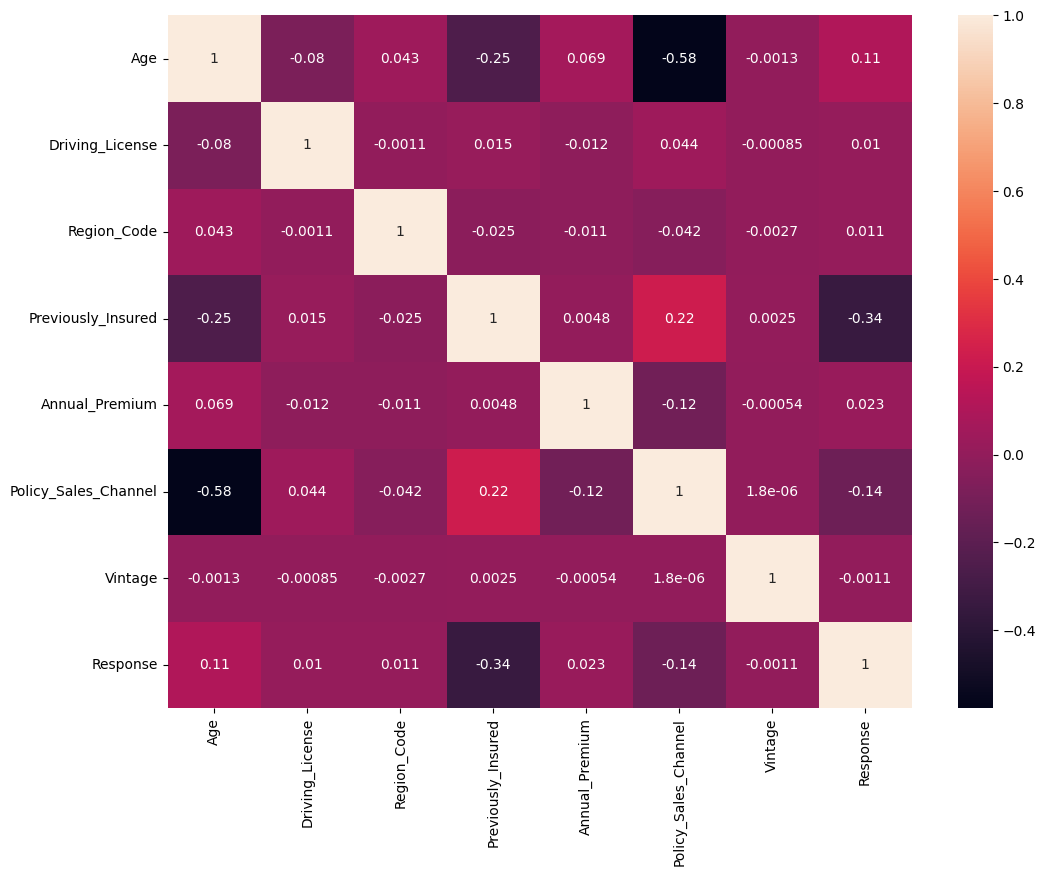

In [36]:
train_corr = train.drop(['id','Vehicle_Age','Vehicle_Damage','Gender'],axis =1)
df2 = df.drop('Vehicle_Damage',axis=1)
df2.corrwith(train["Response"]).sort_values(ascending=False)
corr_df = train_corr.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr_df, annot=True, xticklabels=corr_df.columns, yticklabels=corr_df.columns)

corr_df = corr_df.corr().unstack().sort_values().drop_duplicates()
corr_df = pd.DataFrame(corr_df, columns=["corr"])
corr_df.index.names = ['1', '2']
corr_df = corr_df.reset_index()
corr_df.sort_values(by="corr", ascending=True).head(30)

high_corr = corr_df[(corr_df["corr"] >= 0.70) | (corr_df["corr"] <= -0.70)]
high_corr

## FEATURE ENGINEERING

In [37]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)

In [38]:
train=pd.get_dummies(train,drop_first=True)

In [39]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,1,1,44,1,28.0,0,40454.0,26.0,217,1,False,True,True
1,2,1,76,1,3.0,0,33536.0,26.0,183,0,False,False,False
2,3,1,47,1,28.0,0,38294.0,26.0,27,1,False,True,True
3,4,1,21,1,11.0,1,28619.0,152.0,203,0,True,False,False
4,5,0,29,1,41.0,1,27496.0,152.0,39,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,30170.0,26.0,88,0,False,False,False
381105,381106,1,30,1,37.0,1,40016.0,152.0,131,0,True,False,False
381106,381107,1,21,1,30.0,1,35118.0,160.0,161,0,True,False,False
381107,381108,0,68,1,14.0,0,44617.0,124.0,74,0,False,True,True


In [40]:
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')

train["premium_age_ratio"] = train["Annual_Premium"]/train["Age"]

train["premium_vintage_ratio"] = train["Annual_Premium"]/train["Vintage"]

train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
0,1,1,44,1,28.0,0,40454.0,26.0,217,1,0,1,1,919.409091,186.423963
1,2,1,76,1,3.0,0,33536.0,26.0,183,0,0,0,0,441.263158,183.256831
2,3,1,47,1,28.0,0,38294.0,26.0,27,1,0,1,1,814.765957,1418.296296
3,4,1,21,1,11.0,1,28619.0,152.0,203,0,1,0,0,1362.809524,140.980296
4,5,0,29,1,41.0,1,27496.0,152.0,39,0,1,0,0,948.137931,705.025641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,1,74,1,26.0,1,30170.0,26.0,88,0,0,0,0,407.702703,342.840909
381105,381106,1,30,1,37.0,1,40016.0,152.0,131,0,1,0,0,1333.866667,305.465649
381106,381107,1,21,1,30.0,1,35118.0,160.0,161,0,1,0,0,1672.285714,218.124224
381107,381108,0,68,1,14.0,0,44617.0,124.0,74,0,0,1,1,656.132353,602.932432


In [41]:
num_feat = ['Age','Vintage','premium_age_ratio','premium_vintage_ratio']
ss = StandardScaler()
train[num_feat] = ss.fit_transform(train[num_feat])

mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

train=train.drop('id',axis=1)

cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes']
for column in cat_feat:
    train[column] = train[column].astype('str')

### Applying the same processes to the Test Data

In [42]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test=pd.get_dummies(test,drop_first=True)
test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')
test["premium_age_ratio"] = test["Annual_Premium"]/test["Age"]
test["premium_vintage_ratio"] = test["Annual_Premium"]/test["Vintage"]
test=test.drop('id',axis=1)

In [43]:
ss = StandardScaler()
test[num_feat] = ss.fit_transform(test[num_feat])


mm = MinMaxScaler()
test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])

In [44]:
for column in cat_feat:
    test[column] = test[column].astype('str')

### Train-Test Split

In [45]:
training_data, testing_data = train.drop('Response', axis=1),train['Response']

In [46]:
x_train, x_test, y_train, y_test = train_test_split(training_data,testing_data, test_size=0.2, random_state=42)

In [47]:
x_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
332803,0,0.011438,1,15.0,0,0.239200,55.0,0.868311,0,0,1,0.762207,-0.241018
116248,1,-0.053030,1,11.0,0,0.097096,26.0,-1.498095,0,0,1,-0.505070,0.797477
255005,1,-1.084517,1,30.0,1,0.203098,152.0,0.139267,1,0,0,1.950175,-0.167140
317474,0,-1.020049,1,41.0,1,0.126090,151.0,1.465888,1,0,0,0.610270,-0.477626
344212,1,1.107392,1,48.0,0,0.000000,154.0,0.007800,0,1,1,-1.449741,-0.640800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,0,-0.955581,1,36.0,1,0.094893,152.0,1.585403,1,0,0,0.059675,-0.526672
365838,1,1.107392,1,35.0,0,0.183920,124.0,1.716870,0,0,1,-0.283800,-0.415878
131932,0,-1.084517,1,2.0,0,0.077204,152.0,-0.936372,1,0,1,-0.081339,-0.213171
146867,1,0.333777,1,32.0,1,0.000000,156.0,-1.235161,0,0,1,-1.428107,-0.576788


In [48]:
x_test

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes,premium_age_ratio,premium_vintage_ratio
200222,0,-1.148985,1,3.0,1,0.084583,160.0,-0.984179,1,0,0,0.112347,-0.147817
49766,1,1.042924,1,15.0,0,0.165893,26.0,-0.625632,0,0,1,-0.377517,0.007921
172201,0,0.140374,1,3.0,0,0.000000,26.0,-0.769051,0,0,1,-1.420720,-0.618129
160713,0,-0.826645,1,11.0,0,0.000000,151.0,1.358324,1,0,0,-1.358213,-0.654036
53272,1,0.785053,1,40.0,0,0.149279,124.0,1.322470,0,0,1,-0.402848,-0.434790
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258403,1,-1.020049,1,15.0,0,0.098894,152.0,0.210976,1,0,1,0.190511,-0.420332
234155,0,-1.213453,1,15.0,1,0.140781,160.0,0.940020,1,0,0,1.191956,-0.416366
24476,0,-0.697709,1,8.0,1,0.223328,152.0,0.605377,1,0,0,1.461115,-0.224851
60423,0,-1.148985,1,3.0,1,0.142599,160.0,-1.199306,1,0,0,1.093108,0.444732


In [49]:
for column in cat_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

In [50]:
for column in num_feat:
    x_train[column] = x_train[column].astype('int')
    x_test[column] = x_test[column].astype('int')

# GRID SEARCH

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37187, number of negative: 267700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 493
[LightGBM] [Info] Number of data points in the train set: 304887, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121970 -> initscore=-1.973908
[LightGBM] [Info] Start training from score -1.973908

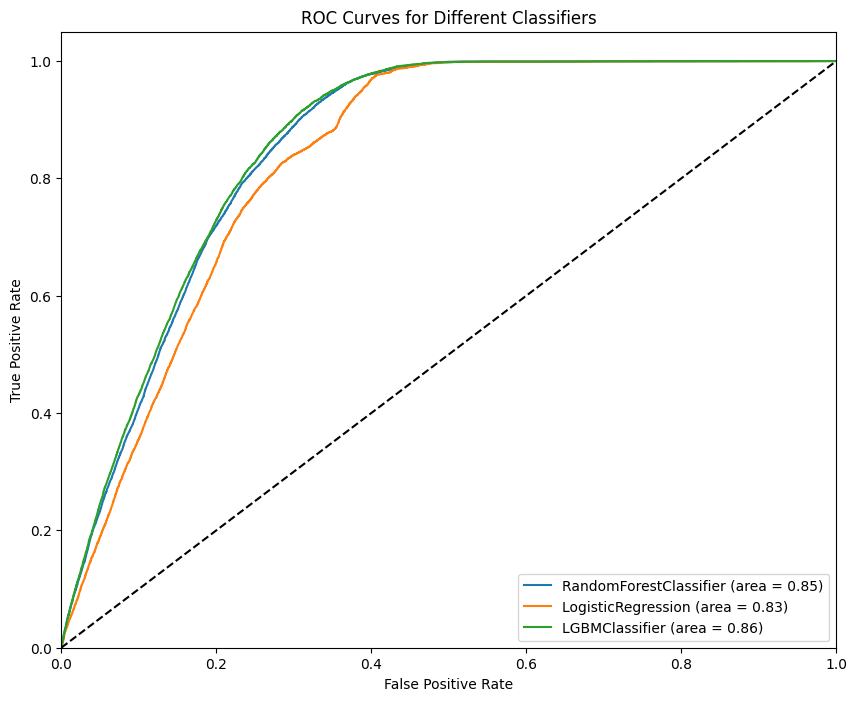

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Definição dos espaços de hiperparâmetros
param_grid = {
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15, None],
        'min_samples_split': [2, 5, 10]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'max_iter': [100, 200]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'LGBMClassifier': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5, 10]
    },
    'CatBoostClassifier': {
        'iterations': [100, 200],
        'learning_rate': [0.05, 0.1],
        'depth': [4, 6, 10]
    }
}

# Criando os modelos
models = {
    'RandomForestClassifier': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression(),
#    'SVC': SVC(probability=True),
    'LGBMClassifier': LGBMClassifier(),
#    'CatBoostClassifier': CatBoostClassifier(verbose=5)
}

# Resultados
results = {}

# Execução do Grid Search com Cross-Validation
for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid[model_name], cv=5, scoring='accuracy', n_jobs=-1, verbose = 5)
    grid_search.fit(x_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)
    y_proba = best_model.predict_proba(x_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    f1score = f1_score(y_test, y_pred)
    results[model_name] = {
        'Best Params': grid_search.best_params_,
        'Best Model': best_model,  # Salvando o modelo ajustado
        'Accuracy': accuracy,
        'F1 Score': f1score,
        'ROC AUC': auc(*roc_curve(y_test, y_proba)[:2])
    }

# Plotagem das Curvas ROC
fig, ax = plt.subplots(figsize=(10, 8))
for model_name, metrics in results.items():
    best_model = metrics['Best Model']  # Obtenção do melhor modelo ajustado para cada classificador
    fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(x_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Different Classifiers')
ax.legend(loc="lower right")
plt.show()
